# **Introduction**
Heart disease is the preeminent cause of global deaths. According to World Health Organisation report, approximately 17.9 million people die each year from cardiovascular diseases(CVDs). This constitutes 31% of deaths worldwide. Therefore, it is very important to develop techniques that could detect any sign of heart problems.

Presently, electrocardiogram(ECG) and echocardiogram are two most successful methods used for detecting heart diseases. In developing countries, auditory auscultation is preferred because it is cheap, but it is also dependent on the physician's skills and is thus, prone to error. Patients who are suspected to have heart abnormalities are then expected to go through a proper diagnosis by a much more expensive procedure like echocardiographic. [1] Though, the detection of heart diseases are possible by using just Auditory Auscultation but they are not accurate. So, deep learning provides a viable alternative to this. 


In a healthy individual, there are two normal heart sounds called "lub" and "dub". They are also known as first heart sound (S1) and second heart sound (S2). They occur in a sequence with each heartbeat.

In this project, I have used real heart audios and attempted to apply deep learning to this domain in order to provide an accurate method for detecting heart anomalies and classify them into four different categories - Normal, Murmur, Extrasystole and Extra Heart Sound. 

1. **Normal Category** - In this category, there are normal and healthy heart sounds. It has a clear “lub dub, lub dub” pattern, where there is shorter time gap from “lub” to “dub” than from “dub” to the next “lub”.
2. **Murmur Category** - Heart murmurs are sounds made by turbulent blood in or near the heart. It often indicates a malfunctioning or overworking heart. Murmer happens between "lub" and "dub" or between "dub" and "lub".
3. **Extrasystole Category** - In this categoy, the heart sound is out of rythm and involves extra or skipped heartbeats, like a “lub-lub dub”. It may or may not be an indication of a heart disease.
4. **Extra Heart Sound Category** - In extra heart sound there is an additional sound, e.g. a “lub-lub dub” or a “lub dub-dub”. It may not indicate a disease, but in some cases it is an important sign of heart disease. [2]

**Objective**
* Classification of heart sounds into 4 different categories - Normal, Murmur, Extrasystole and Extra Heart Sound.
* Comparing the performance of 3 different neural network models - Convolutional Neural Network(CNN), Long-Short Term Memory(LSTM) and CNN+LSTM model. It is observed that CNN is the best model for heart anomaly classification as it gives an accuracy of 91%.
* Comparing the performance of 3 optimisation algorithms on CNN model. These optimisers are Adam, Adamax and Nadam. It is observed that Adam optimiser is the best optimiser.


# **Part I - Data** 

### **Data Description**
The dataset was used in a Machine Learning challenge by Peter Bentley, Glenn Nordehn, Miguel Coimbra, Shie Mannor and Rita Getz. The dataset was gathered from two sources - 
1. General public via the iStethoscope Pro iPhone app.
2. A clinic trial in hospitals using the digital stethoscope DigiScope.


The dataset is divided into 2 sets - set A and set B. This based on the sources they had been collected from. Audios in set A was collected from the general public, while the wudios contained in set B was collected from the clinic trial in hospitals. 
Set A has 4 categories of heartbeats - 
1. Normal
2. Murmur
3. Extra Heart Sound
4. Artifact

Set B has 3 categories of heartbeats - 
1. Normal
2. Murmur
3. Extrasystole

Dataset A contains 176 files in WAV format and dataset B contains 656 files in WAV format.

### **Importing Libraries**

In [0]:
import wave
import contextlib
import os
import glob
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd
from scipy.io import wavfile
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,InputLayer, LSTM, Flatten, Dropout, GlobalMaxPooling1D, Conv1D, Activation,MaxPool1D
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import re

### **Data Pre-Processing**


Data pre-processing involves the following steps - 
1. Combining the two datasets - set-a and set-b
2. Keeping only those audio files which are of duration greater than 3 seconds.
3. Slicing the longer files into multiple short audio files of duration 3 seconds each. This is done to increase the  number of audio files that will be used for testing and training and also to make them all of same length. To do this "repetition" variable is used, which ensures a 1 second overlap between the sliced audio files. This acts as an offset parameter, which is later used during the loading phase.
4. Offset values calculated using 'repetition' are added along with the name of the audio file and the label to a pandas dataframe. This dataframe is then queried by the librosa package while loading the files. At this stage, each audio file is sliced with the help of the offset parameter, and the files are selected with a duration of 3 seconds.

In [6]:
audio_data = []
for directory in ['/content/drive/My Drive/heartbeat-sounds/set_b/*', '/content/drive/My Drive/heartbeat-sounds/set_a/*']:
    for files in glob.iglob(directory):
        if os.path.exists(files):
            label = os.path.basename(files).split("_")[0]
            audio_duration = librosa.get_duration(filename=files)
            
             # selecting files with duration greater than 3 seconds
            if audio_duration>=3:
                split_audio = 3

                # slicing the files 
                repetition = int((audio_duration-split_audio)/(split_audio-1))
                repetition += 1

                initial_gap = (audio_duration - ((repetition*(split_audio-1))+1))/2

                 # adding the label, file name and offset values
                if label in [ "normal","murmur","extrastole","extrahls"]:
                    for i in range(repetition):
                        time_gap = initial_gap + i*(split_audio-1)
                        if (label == "normal"):
                            audio_data.append({
                                "files": files,
                                "label": "normal",
                                "time_gap": time_gap
                            })
                        elif (label == "murmur"):
                            audio_data.append({
                                "files": files,
                                "label": "murmur",
                                "time_gap": time_gap
                            })
                        elif (label == "extrastole"):
                            audio_data.append({
                                "files": files,
                                "label": "extrastole",
                                "time_gap": time_gap
                            })
                        elif (label == "extrahls"):
                            audio_data.append({
                                "files": files,
                                "label": "extrahls",
                                "time_gap": time_gap
                            })
# converting to pandas data frame
audio_data = pd.DataFrame(audio_data)
audio_data = shuffle(audio_data, random_state=42)
audio_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   files     1281 non-null   object 
 1   label     1281 non-null   object 
 2   time_gap  1281 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


In [0]:
data_dir_b = "/content/drive/My Drive/heartbeat-sounds/set_b"
data_dir_a = "/content/drive/My Drive/heartbeat-sounds/set_a"

# **Part II - Data Visualisation**

### **Plot functions**

In [0]:
# this function returns sampling rate, sample frame and duration of the audio
def file_name_info(file_name):
  wav = wave.open(file_name)
  sampling_rate = wav.getframerate()
  sample_frame = wav.getnframes()
  duration = wav.getnframes()/wav.getframerate()
  return sampling_rate, sample_frame, duration



In [0]:
# plotting waveform
def wave_plot(audio_file_name,title):
    y, sr = librosa.load(audio_file_name)
    plt.figure(figsize=(8, 2))
    librosa.display.waveplot(y, sr=sr)
    plt.title(title)
    


In [0]:
# plotting mel spectogram
def mel_spectogram(audio_file_name, title):
    y, sr = librosa.load(audio_file_name)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    plt.figure(figsize=(7,3))
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(title)

In [0]:
# plotting Mel-Frequency Cepstral Coefficient
def mfcc_plot(audio_file_name, title):
    y, sr = librosa.load(audio_file_name)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    plt.figure(figsize=(8, 2))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(title)
    

In [0]:
# Loss Curves
def loss_curve(model_name,loss,val_loss):
  plt.figure(figsize=[12,8])
  plt.subplot(211)
  plt.plot(model_name.history[loss])
  plt.plot(model_name.history[val_loss])
  plt.legend(['Training loss', 'Validation Loss'])
  plt.xlabel('No. of epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curves')


In [0]:
# Accuracy Curves
def accuracy_curve(model_name,acc,val_acc):
  plt.figure(figsize=[12,8])
  plt.subplot(212)
  plt.plot(model_name.history[acc])
  plt.plot(model_name.history[val_acc])
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel('No. of epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves')

In [0]:
# validation loss and training loss plot
def plot_loss(loss):
    plt.figure(figsize=(12,6))
    plt.plot(loss[0], label='Nadam',linewidth=2.0)
    plt.plot(loss[1], label='Adamax', linewidth=2.0)
    plt.plot(loss[2], label='Adam', linewidth=2.0)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

# validation accuracy and training accuracy plot
def plot_acc(acc):
    plt.figure(figsize=(12,6))
    plt.plot(acc[0], label='Nadam',linewidth=2.0)
    plt.plot(acc[1], label='Adamax', linewidth=2.0)
    plt.plot(acc[2], label='Adam', linewidth=2.0)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.show()



### **Audio Sound Overview**
Sound waves are digitised by sampling them at discrete intervals known as the sampling rate. Each sample is the amplitude of the wave at a particular time interval, where the bit depth determines how detailed the sample will be also known as the dynamic range of the signal. 



#### **1. Normal Heart Sound**

In [15]:
normal_file = data_dir_a + "/normal__201106111136.wav"
print("Sampling rate =", file_name_info(normal_file)[0])
print("Sample frame =", file_name_info(normal_file)[1])
print("Duration =", file_name_info(normal_file)[2])

Sampling rate = 44100
Sample frame = 218903
Duration = 4.963786848072562


In [16]:
ipd.Audio(normal_file) 

#### **2. Murmur Heart Sound**

In [17]:
murmur_file = data_dir_b + "/murmur__195_1308140095331_C1.wav"
print("Sampling rate =", file_name_info(murmur_file)[0])
print("Sample frame =", file_name_info(murmur_file)[1])
print("Duration =", file_name_info(murmur_file)[2])

Sampling rate = 4000
Sample frame = 16952
Duration = 4.238


In [18]:
ipd.Audio(murmur_file) 

#### **3. Extrasystole Heart Sound**

In [19]:
extrastole_file = data_dir_b + "/extrastole__127_1306764300147_C2.wav"
print("Sampling rate =", file_name_info(extrastole_file)[0])
print("Sample frame =", file_name_info(extrastole_file)[1])
print("Duration =", file_name_info(extrastole_file)[2])

Sampling rate = 4000
Sample frame = 18704
Duration = 4.676


In [20]:
ipd.Audio(extrastole_file)

#### **4. Extra Heart Sound**

In [21]:
extrahls_file= data_dir_a + "/extrahls__201101161027.wav"
print("Sampling rate =", file_name_info(extrahls_file)[0])
print("Sample frame =", file_name_info(extrahls_file)[1])
print("Duration =", file_name_info(extrahls_file)[2])

Sampling rate = 44100
Sample frame = 262646
Duration = 5.9556916099773245


In [22]:
ipd.Audio(extrahls_file)

### **Plotting the graphs**

 **1) Waveform**
 
Waveforms are time domain representations which compare amplitude over time. 

From the figures below, it can be seen that the waveform of extra heart sound is very different from that of normal, murmur and extrastole heart sounds. 

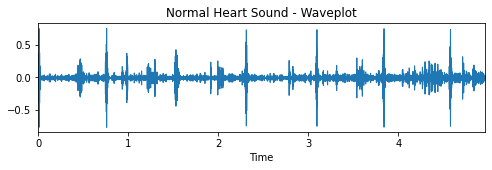

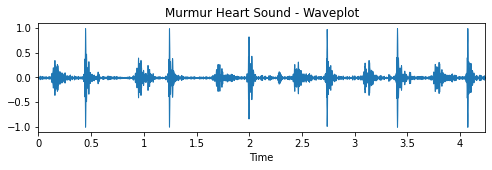

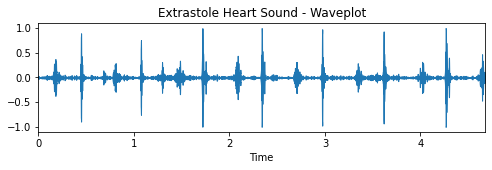

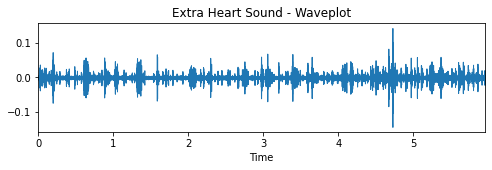

In [24]:

wave_plot(normal_file,"Normal Heart Sound - Waveplot")
wave_plot(murmur_file,"Murmur Heart Sound - Waveplot")
wave_plot(extrastole_file,"Extrastole Heart Sound - Waveplot")
wave_plot(extrahls_file, "Extra Heart Sound - Waveplot")


### **2) Mel-Frequency Cepstral Coefficient** 
One of the useful ways for visualising the spectrum of frequencies of a sound is spectograms. They tell us how sound frequencies vary over a short time period. Mel-Frequency Cepstral Coefficients(MFCC) is a similar technique. It uses quasi-logarithmic spaced frequency scale and it resembles the way human auditory system responds to sound. It is often used in speech recognition.



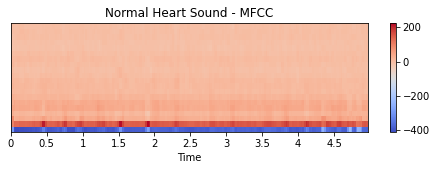

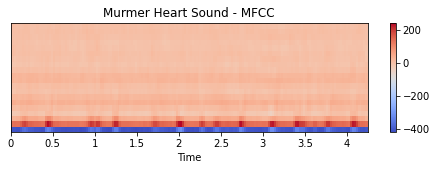

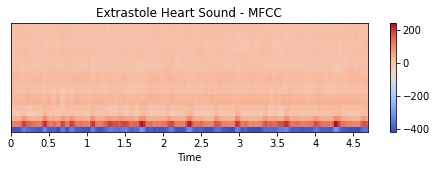

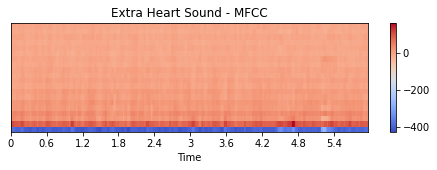

In [25]:
mfcc_plot(normal_file,"Normal Heart Sound - MFCC")
mfcc_plot(murmur_file,"Murmer Heart Sound - MFCC")
mfcc_plot(extrastole_file,"Extrastole Heart Sound - MFCC")
mfcc_plot(extrahls_file,"Extra Heart Sound - MFCC" )


### **3) Mel Spectogram**

Mel spectorgram is a spectogram where the frequencies are converted to the mel scale. The mel scale, named by Stevens, Volkmann, and Newman in 1937, is a perceptual scale of pitches judged by listeners to be equal in distance from one another. [3] The figures below shows the mel spectogram of normal, murmur, extrasystole and extra heart sound.

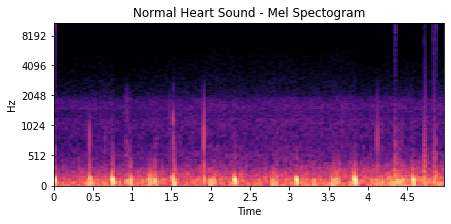

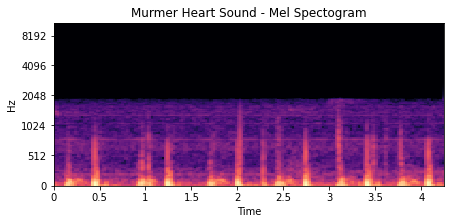

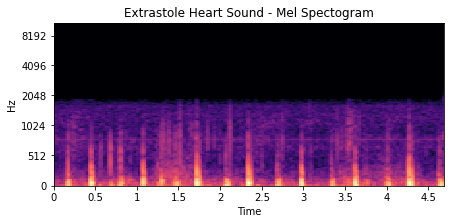

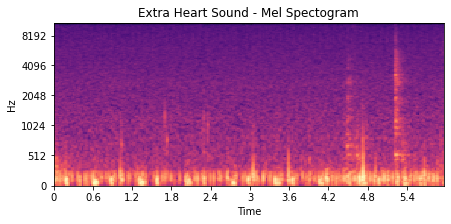

In [26]:
mel_spectogram(normal_file, "Normal Heart Sound - Mel Spectogram")
mel_spectogram(murmur_file, "Murmer Heart Sound - Mel Spectogram")
mel_spectogram(extrastole_file, "Extrastole Heart Sound - Mel Spectogram")
mel_spectogram(extrahls_file, "Extra Heart Sound - Mel Spectogram")


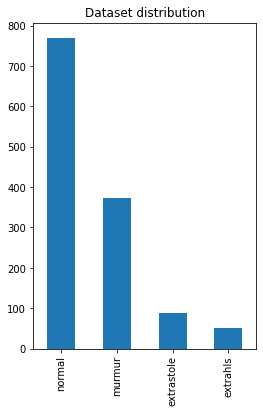

In [27]:
plt.figure(figsize=(4,6))
audio_data.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

# **Part IV - Creating training and testing sets**

#### **Feature Extraction**
The audio files that I am using are in waveform audio file format. This means that it is a time domain representation which compares amplitude over time. I have transformed this one dimensional waveform into a two dimensional time frequency heatmap representation using Mel-Frequency Cepstral Coefficient (MFCC) [4]. This is done because of the presence of variantion in range of amplitudes due to the fact that the audios were acquired using different tools like stethoscopes and mobile phone.  So, tranforming the audios into time frequency heatmaps gives better outut.

The image below explains the following steps to calculate MFCC - 
1. Frame the audio signal into short frames. 
2. Apply fourier transform to extract information in the frequency domain. 
3. Apply mel filters i.e filter bank converts it to mel scale. It outputs a power spectrum. 
4. Take the log of the above output. It leads to reduction of acoustic variants which are insignificant in speech recognition. 
5. Take the Discrete Cosine Transform of the log filterbanks ergies to give cepstral coefficients which are nothing but MFCCs. 

The cepstral vectors obtained is then given to the model for classification problem.

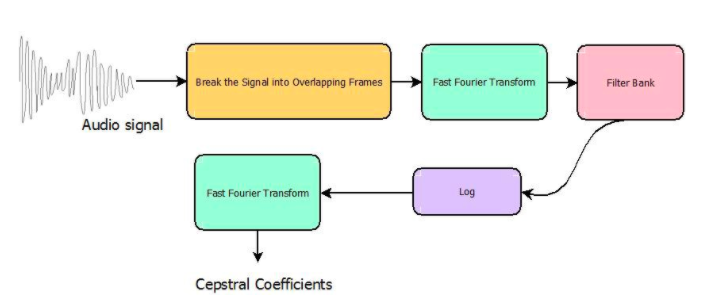

In [0]:
Image('MFCC.png')

In [28]:
# splitting the data into tarining and testing set
train_data, test_data = train_test_split(audio_data, test_size=0.2, random_state=42)
print(len(train_data))
print(len(test_data))

1024
257


In [30]:
x_train = []
x_test = []

for i in range(1024):

  # feature extraction 
  # load audio files with duration length equal 3 seconds
  y, sr = librosa.load(train_data.files.iloc[i], offset=train_data.time_gap.iloc[i], duration=3)

  # computing a mel-scaled spectrogram, n_fft, hop_length and n_mel have default values
  S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
  
  mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

  # generating mfccs by converting a power spectrogram to decibel (dB) units

  x_train.append(mfccs)

for i in range(257):
  
  # feature extraction 
  # load audio files with duration length equal 3 seconds
  y, sr = librosa.load(test_data.files.iloc[i], offset=test_data.time_gap.iloc[i], duration=3)

  # computing a mel-scaled spectrogram
  S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
  
  # generating mfccs 
  mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
  x_test.append(mfccs)
    
# converting x test and x train to numpy array    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("Shape of x train =", x_train.shape)
print("Shape of x test =", x_test.shape)

Shape of x train = (1024, 40, 130)
Shape of x test = (257, 40, 130)


In [31]:
# label encoding
le = LabelEncoder()
le.fit(train_data.label)

# fit label encoder and return encoded labels
y_train = le.transform(train_data.label)
y_test = le.transform(test_data.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = dict(enumerate(class_weights))

# Reshaping x train and x test in order to use conv2D
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# converting the class vector into matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Shape of x train =", x_train.shape)
print("Shape of y train =", y_train.shape)
print("Shape of x test =", x_test.shape)
print("Shape of y test =", y_test.shape)

Shape of x train = (1024, 40, 130, 1)
Shape of y train = (1024, 4)
Shape of x test = (257, 40, 130, 1)
Shape of y test = (257, 4)


# **Part V - Building Deep Learning Models**

### **1. Convolutional Neural Network (CNN)**

Convolutional neural network is mainly used for image classification. Since, the one dimensional audios are converted into two dimensional time frequency representation, each heart sound can be processed as an image. 

I have used a 2-D convolution based CNN model. The network architecture of the convolutional network accepts a single channel 40 x 130 MFCC heat map and outputs multiclass classification. It classifies the heart sound as normal, nurmur, extrahls and extrasystole. 

Different kinds of layers can be added into the network architecture. I have used the following layers - 
1. **Convolutional layer** - In convolutional layer multiple filters are applied to the image to extract features. I have used 4 convolutional layers. The first layer has 64 filters, the second and third layers have 128 filter and the fourth layer has 256 filters. All the layers have kernel size equal to 2 and use the same padding. The convolutional layers use Rectified Linear Unit algorithm (ReLu) as activation function.
2. **Pooling layer** - Pooling layer performs dimenionality reduction by performing a specific function like max pooling. Max pooling takes the maximum value in a filter region. I have used pool size equal to 2 in all 4 layers.
3. **Dropout layer** - This layer randomly drops data, this might help in reducing overfitting. The dropout rate for the first 3 layers is 0.25 and that of the 4th layer is 0.5. Dropout rate is the probability at which the layers are dropped out.
4. **Global average pooling layer** - It is used to minimise overfitting. It reduces the total number of parameters in the model.
5. **Dense Layer** - In this layer every input is conneced to every output by a weight. The activation function used here is a softmax algorithm.

The hyper-parameter settings for the model are - 
1. **learning rate** = 0.00001
2. **Mini-batch size** = 256
3. **Number of epochs** = 350

The optimising algorithm used here is Adam. It is a combination of RMSprop and Stochastic Gradient Descent with momentum. It is an adaptive learning rate method. I have used categorical cross entropy as loss function.

In order to check the performance of the two models, the following performance metrics have been used - 

* **Accuracy** - It refers to the proportion of correct predictions made by the model.   

* **Precision** - It tells what proportion of positive identification was actually right.

* **Recall** - It tells what proportion of actual positives was identified correctly.

* **F1-Score** - It is the harmonic mean of precision and recall.

* **Confusion Matrix** - It shows the actual and predicted labels from a classification problem.


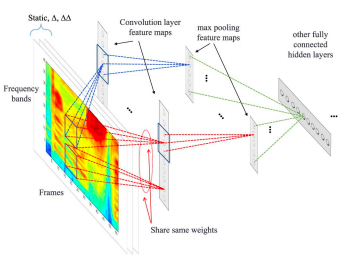

In [0]:
Image('CNN.png')

In [32]:
model = Sequential()

# convolutional layer
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]),padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2,padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=2, padding="same", activation='relu'))

# maxpooling layer
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# dropout layer
model.add(tf.keras.layers.Dropout(0.5))

# global average pooling layer
model.add(tf.keras.layers.GlobalAveragePooling2D())

# dense layer
model.add(Dense(len(le.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 130, 64)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 65, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 65, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 65, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 32, 128)       6

In [0]:
# optimisation algorithm
adam = tf.python.keras.optimizers.Adam(lr=0.00001)

# compiling model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# fitting the model
adam_model = model.fit(x_train, y_train,
              batch_size=256,
              epochs=350,
              class_weight=class_weights,
              callbacks = [ModelCheckpoint('CNN.h5', monitor='val_accuracy',mode='max',save_best_only=True)],
              validation_data=(x_test, y_test),
              shuffle=True)
              

Epoch 1/350
4/4 [==============================] - 0s 87ms/step - loss: 11.5657 - accuracy: 0.2949 - val_loss: 2.6904 - val_accuracy: 0.0700
Epoch 2/350
4/4 [==============================] - 0s 59ms/step - loss: 3.7706 - accuracy: 0.1455 - val_loss: 0.8960 - val_accuracy: 0.6109
Epoch 3/350
4/4 [==============================] - 0s 52ms/step - loss: 1.9771 - accuracy: 0.5273 - val_loss: 1.1152 - val_accuracy: 0.5292
Epoch 4/350
4/4 [==============================] - 0s 53ms/step - loss: 1.4760 - accuracy: 0.2637 - val_loss: 1.5090 - val_accuracy: 0.1868
Epoch 5/350
4/4 [==============================] - 0s 52ms/step - loss: 1.2106 - accuracy: 0.1924 - val_loss: 1.3536 - val_accuracy: 0.3346
Epoch 6/350
4/4 [==============================] - 0s 53ms/step - loss: 1.1244 - accuracy: 0.3340 - val_loss: 1.1238 - val_accuracy: 0.5953
Epoch 7/350
4/4 [==============================] - 0s 52ms/step - loss: 1.0245 - accuracy: 0.5381 - val_loss: 1.0592 - val_accuracy: 0.6109
Epoch 8/350
4/4 [==

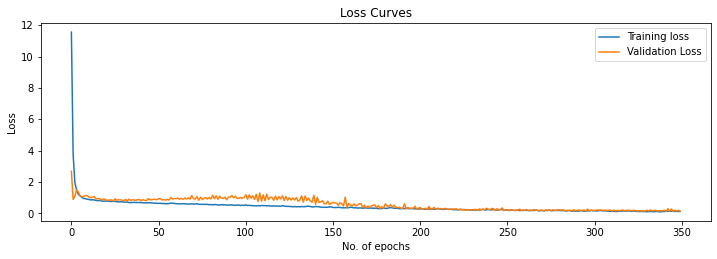

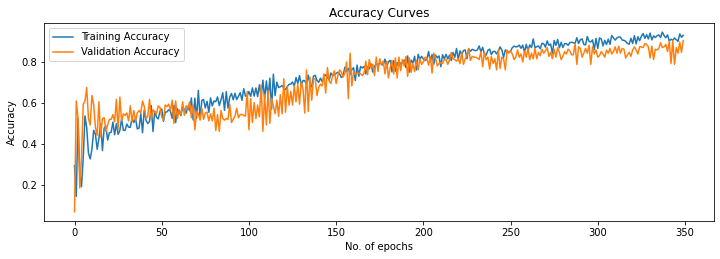

In [0]:
# plotting loss curve and accuracy curve
loss_curve(adam_model,"loss","val_loss")
accuracy_curve(adam_model,"accuracy","val_accuracy")

In [0]:
# saving the model
cnn_model = tf.python.keras.models.load_model('CNN.h5')
adam_predictions = cnn_model.predict(x_test, verbose=1)


9/9 [==============================] - 0s 3ms/step


In [0]:
# prediction and clasification report
y_true, y_pred = [],[]
classes = le.classes_
for idx, prediction in enumerate(adam_predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

    extrahls       0.92      0.86      0.89        14
  extrastole       0.67      0.71      0.69        17
      murmur       0.93      0.93      0.93        73
      normal       0.92      0.92      0.92       153

    accuracy                           0.91       257
   macro avg       0.86      0.85      0.86       257
weighted avg       0.91      0.91      0.91       257



In [0]:
# finding confusion matrix 

from sklearn.metrics import multilabel_confusion_matrix
y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
modified_ytest = np.argmax(y_test,axis=1)
labels = ["Extrahls","Extrastole","Murmer","Normal"]

conf_mat = multilabel_confusion_matrix(modified_ytest,y_pred,labels = [0, 1, 2,3])
for i in range(4):
  print(labels[i])
  print(conf_mat[i])

Extrahls
[[242   2]
 [  1  12]]
Extrastole
[[234   5]
 [  6  12]]
Murmer
[[179   5]
 [  5  68]]
Normal
[[ 92  12]
 [ 12 141]]


**Observation**

1) The classification report indicates that:
* The test accuracy and F1-score of CNN model is 0.91.
* The F1-score for extra heart sound, murmur and normal heart sounds is 0.89, 0.93 and 0.92 respectively. So, the model does a good job in classifying the heart sound as extra heart sound, murmur or normal.
* The F1-score of extrastole is quite low as it is just 0.69. 

2) The confusion matrix indicates that:
* True negatives for Extrahls, Extrastole, Murmur and Normal are 242, 234, 179 and 92 respectively.
* True positives for Extrahls, Extrastole, Murmur and Normal are 12, 12, 68 and 141 respectively.  
* False positives for Extrahls, Extrastole, Murmur and Normal are 2, 5, 5 and 12 respectively.
* False negatives for Extrahls, Extrastole, Murmur and Normal are 1, 6, 5 and 12 respectively.

It can be seen that our model has correctly predicted 12 out of 13 as extra heart sounds and it is able to predict 242 as 'not extrahls'. So, our model is doing pretty well in case of extrahls as there are very few false. Similarly, the model is doing a good job in predicting murmur and normal heart sounds. However, out of 18, only 12 extrasystole heart sounds were predicted correctly. This shows that this model has not performed well in predicting extrasystole heart sounds.

### **2. Long-Short Term Memory (LSTM)**

#### **Reshaping x train and x test for LSTM**

In [41]:
from tqdm import tqdm
x1_train = []
x1_test = []

for i in tqdm(range(1024)):

  # feature extraction 
  # load audio files with duration length equal 3 seconds
  y, sr = librosa.load(train_data.files.iloc[i], offset=train_data.time_gap.iloc[i], duration=3)

 
  # generating mfccs
  mfccs1 = np.mean(librosa.feature.mfcc(y, sr=sr, n_mfcc=40).T,axis=0) 
  features = np.array(mfccs1).reshape([-1,1])
  x1_train.append(features)

for i in tqdm(range(257)):

  # feature extraction 
  # load audio files with duration length equal 3 seconds
  y, sr = librosa.load(test_data.files.iloc[i], offset=test_data.time_gap.iloc[i], duration=3)
  
  # get normalized mfcc feature from data 
  mfccs1 = np.mean(librosa.feature.mfcc(y, sr=sr, n_mfcc=40).T,axis=0) 
  features = np.array(mfccs1).reshape([-1,1])
  x1_test.append(features)
    
    
x1_test = np.asarray(x1_test)
x1_train = np.asarray(x1_train)

print("X train:", x1_train.shape)
print("X test:", x1_test.shape)

100%|██████████| 257/257 [01:15<00:00,  3.39it/s]

X train: (1024, 40, 1)
X test: (257, 40, 1)


In [0]:
# encoding labels
le = LabelEncoder()

# fit label encoder
le.fit(train_data.label)

# fit label encoder and return encoded labels
y1_train = le.transform(train_data.label)
y1_test = le.transform(test_data.label)

# using class weights to balance the data
class_weights = class_weight.compute_class_weight('balanced',np.unique(y1_train),y1_train)
class_weights = dict(enumerate(class_weights))

In [43]:
# Converts a class vector to matrix.
y1_train = to_categorical(y1_train)
y1_test = to_categorical(y1_test)
print("Y train:", y1_train.shape)
print("Y test:", y1_test.shape)

Y train: (1024, 4)
Y test: (257, 4)


#### **LSTM Model Description**
LSTM network models are a form of recurrent neural network. They have internal mechanisms called gates. They are able to learn and remember long sequences of input data. The main difference between a vanilla RNN and an LSTM is that the LSTM contains what is known in simple terms as a "memory unit". This essentially is what makes the LSTM good at remembering sequences. The model learns to extract features from sequences of observations and how to map the internal features to different activity types. It also contains what is known as a "forget gate", where less important information is deleted. The gates help regulating the flow of information by keeping important information and deleting the less important ones.

LSTM model requires 3 dimensional input. The model is defined as Squential Keras model. The network architecture has 2 hidden LSTM layers with dropout rate 0.2 and recurrent dropout rate 0.35. This is followed by a dense layer which is a connected layer. It uses the features extracted by LSTM hidden layers, interprets it and produces the final output layer which is used to make predictions. The dense layer uses softmax activation function. 

The optimizing algorithm used here is Adam and the loss function is categorical cross entropy.

The hyper-parameter settings are -
1. Learning rate = 0.001
2. Batch size = 32
3. Epochs = 400



In [44]:

model = Sequential()

# LSTM layer
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.35, return_sequences=True,input_shape = [40,1]))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.35, return_sequences=False))

# Dense layer
model.add(Dense(len(le.classes_), activation='softmax'))

# optimisation algorithm
adam = tf.python.keras.optimizers.Adam(lr=0.001)

# model compilation
adam_model = model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()  


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 29,444
Trainable params: 29,444
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fitting the model
history = model.fit(x1_train, y1_train,
              batch_size=32,
              epochs=400, 
              class_weight=class_weights,
              callbacks = [ModelCheckpoint('LSTM.h5', monitor='val_acc',mode='max',save_best_only=True)],
              validation_data=(x1_test, y1_test),
              verbose=1)  

Epoch 1/400
32/32 [==============================] - 4s 122ms/step - loss: 1.0477 - acc: 0.3652 - val_loss: 1.3792 - val_acc: 0.1323
Epoch 2/400
32/32 [==============================] - 4s 112ms/step - loss: 0.9251 - acc: 0.2295 - val_loss: 1.1318 - val_acc: 0.2646
Epoch 3/400
32/32 [==============================] - 3s 109ms/step - loss: 0.9054 - acc: 0.2686 - val_loss: 1.1243 - val_acc: 0.2218
Epoch 4/400
32/32 [==============================] - 4s 110ms/step - loss: 0.8836 - acc: 0.3799 - val_loss: 1.2257 - val_acc: 0.1829
Epoch 5/400
32/32 [==============================] - 4s 111ms/step - loss: 0.8920 - acc: 0.3682 - val_loss: 1.0911 - val_acc: 0.4047
Epoch 6/400
32/32 [==============================] - 3s 107ms/step - loss: 0.8544 - acc: 0.3750 - val_loss: 1.1971 - val_acc: 0.2412
Epoch 7/400
32/32 [==============================] - 4s 112ms/step - loss: 0.8438 - acc: 0.3926 - val_loss: 1.0632 - val_acc: 0.4125
Epoch 8/400
32/32 [==============================] - 4s 111ms/step - 

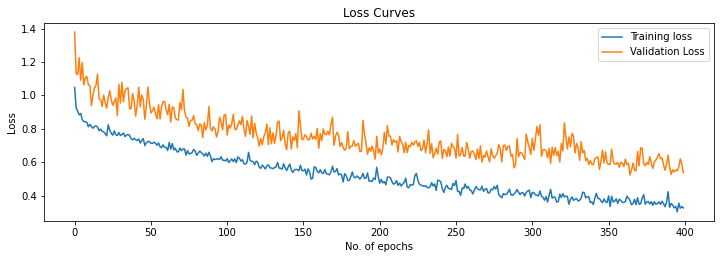

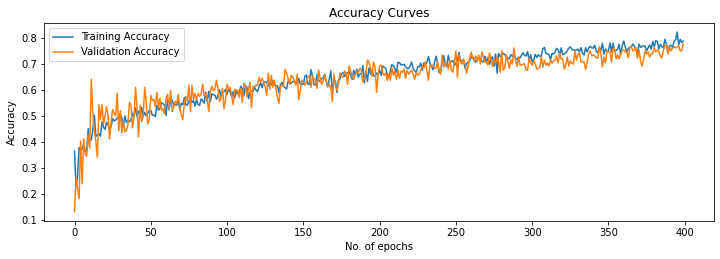

In [0]:
# plotting loss and accuracy curves 
loss_curve(history,"loss","val_loss")
accuracy_curve(history,"acc","val_acc")

In [0]:
# saving the model
lstm_model = tf.python.keras.models.load_model('LSTM.h5')

# predicting and printing classification report
adam_predictions_lstm = lstm_model.predict(x1_test, verbose=1)
y1_true, y1_pred = [],[]
classes = le.classes_
for idx, prediction in enumerate(adam_predictions_lstm): 
    y1_true.append(classes[np.argmax(y1_test[idx])])
    y1_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y1_pred, y1_true))

9/9 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.68      0.81        19
  extrastole       0.72      0.46      0.57        28
      murmur       0.79      0.74      0.77        78
      normal       0.76      0.88      0.81       132

    accuracy                           0.78       257
   macro avg       0.82      0.69      0.74       257
weighted avg       0.78      0.78      0.77       257



In [0]:
# getting confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
y1_pred = lstm_model.predict(x1_test)
y1_pred = np.argmax(y1_pred, axis = 1)
modified_y1test = np.argmax(y1_test,axis=1)
labels = ["Extrahls","Extrastole","Murmer","Normal"]

conf_mat = multilabel_confusion_matrix(modified_y1test,y1_pred,labels = [0, 1, 2,3])
for i in range(4):
  print(labels[i])
  print(conf_mat[i])

Extrahls
[[238   6]
 [  0  13]]
Extrastole
[[224  15]
 [  5  13]]
Murmer
[[164  20]
 [ 15  58]]
Normal
[[ 88  16]
 [ 37 116]]


**Observation**

1) The classification report indicates that:
* The test accuracy and F1-score of LSTM model is 0.78.
* The F1-score for extra heart sound, murmur and normal heart sounds is 0.81, 0.77 and 0.81 respectively. So, the model is not doing a great job in classifying the heart sound as extra heart sound, murmur or normal.
* The F1-score of extrastole is quite low as it is just 0.57. 

2) The confusion matrix indicates that:
* True negatives  for Extrahls, Extrastole, Murmur and Normal are 238, 224, 164 and 88 respectively.
* True positives for Extrahls, Extrastole, Murmur and Normal are 13, 13, 58 and 116 respectively.
* False positives for Extrahls, Extrastole, Murmur and Normal are 6, 15, 20 and 16 respectively.
* False negatives for Extrahls, Extrastole, Murmur and Normal are 0, 5, 15 and 37 respectively.

LSTM model has done an excellent job at predicting extra heart sounds as it has predicted all the extra heart sounds correctly. The model has predicted only 76%, 79% and 72% of normal, murmur and extrasystoe heart sounds correctly. 

### **3. LSTM+CNN**

The CNN Long Short-Term Memory Network is an LSTM architecture which is mainly designed for sequence prediction problems with spatial inputs, like images or videos. A simple LSTM model doesn't perform well in image classificaton. So, we can use CNN LSTM architecture.

In CNN LSTM architecture, we have convolutional neural network layers for feature extraction and LSTM for sequence prediction. 

The network architecture consists two convolutional layers with filter size 128 and 256 and activation function ReLu respectively, a single LSTM layer, a global average pooling layer and finally a dense layer which uses softmax as activation function. 

The hyper-parameter settings for the model are - 
1. learning rate = 0.001
2. Mini-batch size = 64
3. Number of epochs = 400

The optimsation algorithm used here is Adam and the loss function is defined as categorical-cross entropy.

In [47]:
model = Sequential()

# convolutional layer
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu',input_shape = [40,1]))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

# LSTM layer
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.35, return_sequences=True))
model.add(tf.keras.layers.GlobalAveragePooling1D())

# Dense Layer
model.add(Dense(len(le.classes_), activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 128)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 256)           65792     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 256)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 9, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 64)            

In [0]:
# defining the optimisation algorithm
adam = tf.python.keras.optimizers.Adam(lr=0.001)

#compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [0]:
# training the model
history = model.fit(x1_train, y1_train,
              batch_size=64,
              epochs=400,
              class_weight=class_weights,
              callbacks = [ModelCheckpoint('CNN-LSTM.h5', monitor='val_acc',mode='max',save_best_only=True)],
              validation_data=(x1_test, y1_test),
              verbose=1) 

Epoch 1/400
16/16 [==============================] - 1s 35ms/step - loss: 1.1688 - acc: 0.3623 - val_loss: 1.0800 - val_acc: 0.4241
Epoch 2/400
16/16 [==============================] - 0s 17ms/step - loss: 0.9335 - acc: 0.4268 - val_loss: 1.3128 - val_acc: 0.1479
Epoch 3/400
16/16 [==============================] - 0s 17ms/step - loss: 0.9124 - acc: 0.3789 - val_loss: 1.1794 - val_acc: 0.2607
Epoch 4/400
16/16 [==============================] - 0s 18ms/step - loss: 0.8986 - acc: 0.4219 - val_loss: 1.1513 - val_acc: 0.3424
Epoch 5/400
16/16 [==============================] - 0s 16ms/step - loss: 0.8790 - acc: 0.2891 - val_loss: 1.0974 - val_acc: 0.3969
Epoch 6/400
16/16 [==============================] - 0s 17ms/step - loss: 0.8512 - acc: 0.4814 - val_loss: 1.1951 - val_acc: 0.2724
Epoch 7/400
16/16 [==============================] - 0s 17ms/step - loss: 0.8463 - acc: 0.3516 - val_loss: 1.0930 - val_acc: 0.3852
Epoch 8/400
16/16 [==============================] - 0s 17ms/step - loss: 0.

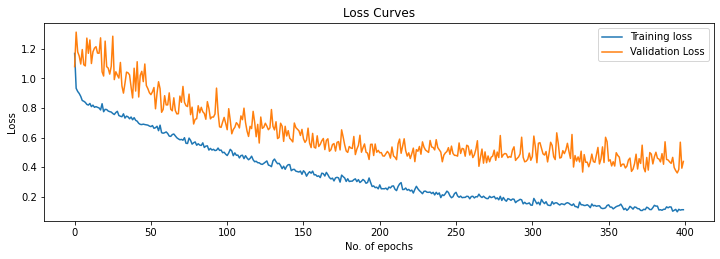

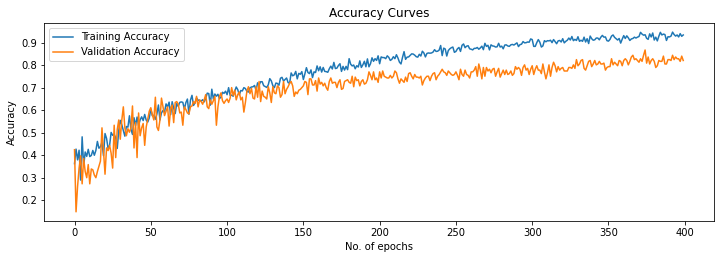

In [0]:
# plotting loss and accuraacy curves
loss_curve(history,"loss","val_loss")
accuracy_curve(history,"acc","val_acc")

In [0]:
# saving the model
cnn_lstm_model = tf.python.keras.models.load_model('CNN-LSTM.h5')

# prediction and classification report
adam_predictions_cl = cnn_lstm_model.predict(x1_test, verbose=1)
y1_true, y1_pred = [],[]
classes = le.classes_
for idx, prediction in enumerate(adam_predictions_cl): 
    y1_true.append(classes[np.argmax(y1_test[idx])])
    y1_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y1_pred, y1_true))

9/9 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

    extrahls       1.00      0.76      0.87        17
  extrastole       0.67      0.57      0.62        21
      murmur       0.93      0.87      0.90        78
      normal       0.85      0.92      0.88       141

    accuracy                           0.87       257
   macro avg       0.86      0.78      0.82       257
weighted avg       0.87      0.87      0.87       257



In [0]:
# confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
y_pred = cnn_lstm_model.predict(x1_test)
y_pred = np.argmax(y_pred, axis = 1)
modified_ytest = np.argmax(y1_test,axis=1)
labels = ["Extrahls","Extrastole","Murmer","Normal"]

conf_mat = multilabel_confusion_matrix(modified_ytest,y_pred,labels = [0, 1, 2,3])
for i in range(4):
  print(labels[i])
  print(conf_mat[i])

Extrahls
[[240   4]
 [  0  13]]
Extrastole
[[230   9]
 [  6  12]]
Murmer
[[174  10]
 [  5  68]]
Normal
[[ 93  11]
 [ 23 130]]


**Observation**

1) The classification report indicates that:
* The test accuracy and F1-score of CNN-LSTM model is 0.87.
* The F1-score for extra heart sound, murmur and normal heart sounds is 0.87, 0.90 and 0.88 respectively. So, the CNN-LSTM model is doing a good job in classifying the heart sound as extra heart sound, murmur or normal.
* The F1-score of extrastole is quite low as it is just 0.62. 

2) The confusion matrix indicates that:
* True negatives for Extrahls, Extrastole, Murmur and Normal are 240, 230, 174 and 93 respectively.
* True positives for Extrahls, Extrastole, Murmur and Normal are 13, 12, 68 and 130 respectively.
* False positives for Extrahls, Extrastole, Murmur and Normal are 4, 0, 10 and 11 respectively.
* False negatives for Extrahls, Extrastole, Murmur and Normal are 0, 6, 5 and 23 respectively.

The model has correctly predicted all the extra heart sounds as extra heart sounds. It has predicted only half of the extrasystole heart beat as extrasystole. It has also done a good job in predicting murmur and normal heart beats. 

**Comparing CNN, LSTM and CNN-LSTM models**
* It can be observed that CNN model performs the best in classification of heart sounds as murmur, normal, extrastole and etrahls. The test accuracy and F1-score of CNN model is 0.91. 
* LSTM model is the worst in classifying the heart sounds as its test accuracy and F1-score is the lowest, which is equal to 0.78
* CNN-LSTM model does a good job in predicting the heart sound with 0.87 accuracy and F1-score. However, its accuracy is lower than CNN model. 


## **Part VI: Comparing different optimisation functions for CNN model**
In this section the performance of three different optimisers have been compared using CNN model as it was the best model for heart sound classification. The following optimisers have been used -

* Adam optimiser - Adam optimisation technique is an extension of Stochastic Gradient Descent (SGD). Adam is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks. It also has a combining advantage of two other extensions of SGD, which are Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).  

* Nadam optimiser - Nadam is Nesterov Adam optimiser. It is essentially RMSprop with Nesterov momentum.

* Adamax optimiser - AdaMax is an adaptation of the Adam optimiser based on infinity norms.

in order to perform the comparison, a python file called "cnn_func" is imported. This python file consists of the CNN architecture using all the three optimisers.

In [0]:
import cnn_func

In [39]:
val_acc_list = []
val_loss_list = []
val_loss_list,val_acc_list = cnn_func.cnn_function(x_train,x_test,y_train,y_test,le,class_weights)

  0%|          | 0/3 [00:00<?, ?it/s]


 Nadam optimiser is currently running...


 33%|███▎      | 1/3 [03:06<06:12, 186.47s/it]


 Adamax optimiser is currently running...


 67%|██████▋   | 2/3 [06:11<03:06, 186.19s/it]


 Adam optimiser is currently running...


100%|██████████| 3/3 [09:17<00:00, 185.77s/it]


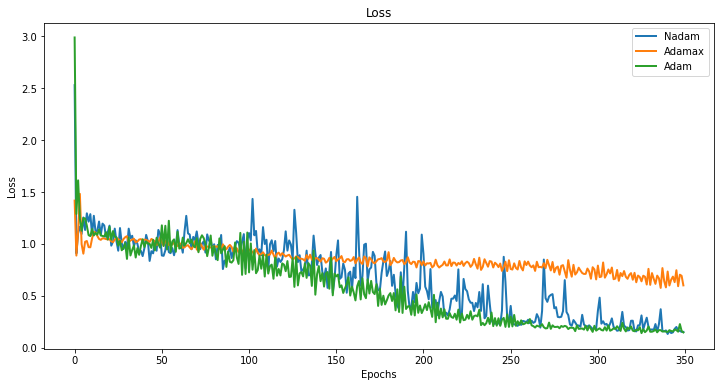

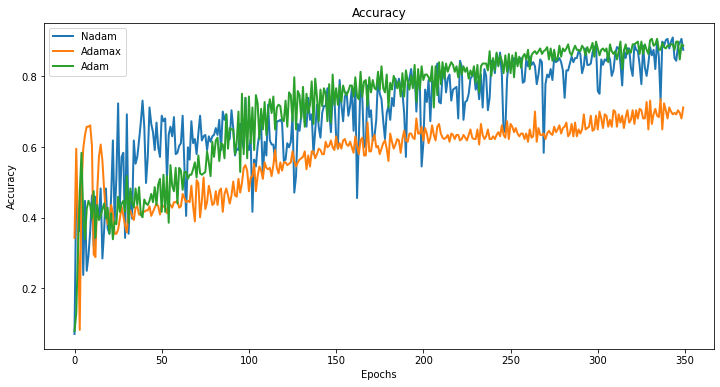

In [0]:
plot_loss(val_loss_list)
plot_acc(val_acc_list)


**Observation:**

* Initially, the loss for optimiser Adam is the most and that of optimiser Adamax is the least. 

* After 10 epochs, loss for optimiser Adamax starts to decrease at a speed lower than that of Adam and Nadam optimisers. 

* Ater 300 epochs, loss for Adamax almost becomes constant.

* Loss for optimiser Adam starts to decrease at a faster pace than that of Nadam and Adamax. Adam's loss is lower than that of Nadam and Adama optimisers for almost all the epochs.

* Adamax optimiser has the highest loss.

* Nadam optimiser has very high fluctuations in both accuracy and loss plots.

* Initially, the accuracy for all the three optimisers is very low. 

* Optimiser Adamax has accuracy lower than that of Nadam and Adam optimisers at almost all epochs.

* After 300 epochs Adamax accuracy almost becomes constant.



* Adam optimiser has higher accuracy than both Nadam and Adamax optimisers at almost all the epochs.

* Adam optimiser performs the best and Adamax optimiser performs the worst.

# **Conclusion**
The aim of this project was to successfully detect heart anomalies by classifying heartbeats as normal, murmur, extrasystole or extra heart sound. The heart audios used for training and testing the model were recorded using  iStethoscope Pro iPhone app and a digital stethoscope DigiScope. The audios were transformed into time frequency heatmaps using Mel-Frequency Cepstral Coefficient (MFCC) for better and accurate results.

In order to detect heart anomalies, three neural network models were built and their performances were compared. It was observed that Convolutional Neural Network model with 4 convolutional layers and a dense layer, with filter sizes 64, 128, 128 and 256 outperformed LSTM and CNN-LSTM models. LSTM model had 2 LSTM layers and a dense layer, and CNN-LSTM model had 2 convolutional layers with filter size 128 and 256, an LSTM layer and a dense layer. 

All the three models used Adam optimisation algorithm but had different learning rate, epochs and batch size. For CNN, LSTM and CNN-LSTM models, the learning rate used was 0.00001, 0.001 and 0.001, mini batch size was 256, 32 and 64, and number of epochs was 350, 400 and 400 respectievly.

CNN model gave the highest training accuracy, test accuracy and F1-score which was equal to 0.9316 and 0.91 respectively. The training accuracy, test accuracy and F1-score of LSTM model was 0.7891 and 0.78 respectively, which was the least and that of CNN-LSTM model was 0.9346 and 0.87 respectively. So, based on the performance metrics, it can be concluded that CNN model did the best job in predicting the classes of heartbeats, while LSTM model did the worst job. Also, CNN-LSTM model performed well in class prediction of the heart sounds.

It was also observed that all the three models did a poor job at correctly predicting extrasystole heart sounds and a great job at correctly predicting extra heart sounds. Though, LSTM gave the least accuracy overall, but it performed better than CNN and CNN-LSTM at predicting extrasystole heart sounds. We can draw two inferences from this - (a) Extra heart sound is probably very distinct from other heart sounds and therefore it is being predicted accurately. (b) Extrasystole heart sound is difficult to distinguish as it might be similar to one of the classes of heart sounds.

After getting the best neural network model, the performance of three different optimisers i.e Adam, Nadam and Adamax were compared. It was observed that Adam was the best optimiser and Adamax was the worst optimiser

Thus, it can be concluded that Convolutional Neual Networks can successfuly extract features from MFCC heatmaps and detect heart anomalies.


# **References**
1. http://www.peterjbentley.com/heartchallenge/

1. Gupta, C. N., Palaniappan, R., Rajan et al. (2005, May).Segmentation and classification of heart sounds. In Canadian Conference on Electrical and Computer Engineering, 2005. (pp. 1674-1677). IEEE.

1. https://en.wikipedia.org/wiki/Mel_scale

1. J. Rubin, R. Abreu, A. Ganguli, S. Nelaturi, I. Matei and K. Sricharan, "Classifying heart sound recordings using deep convolutional neural networks and mel-frequency cepstral coefficients," 2016 Computing in Cardiology Conference (CinC), Vancouver, BC, 2016, pp. 813-816
1. B. J. Gersh, Auscultation of cardiac murmurs in adults. In: UpToDate, (2015).
2. T. Oskiper and R. Watrous, Detection of the first heart sound using a time-delay neural network in Computers in Cardiology, 2002 , 2002.
3. S. R. Bhatikar, C. DeGroff, and R. L. Mahajan, "A classifier based on the artificial neural network approach for cardiologic auscultation in pediatrics", ArtifiCial Intelligence in MediCine, vol.33, pp 251-260, 2005.

5. K. Ejaz., et al "Heart Murmur Detection System Using Spectrograms and Artificial Neural Networks", International Association of Science and Technology for Development Conference (IASTED):Circuits, Signals and Systems (CSS), pp. 374-379, Clearwater, FL, Nov. 28- Dec. 1,2004.
6. Bushaev Vitaly "Adam — latest trends in deep learning optimization.", 2018
7. Gomes, Elsa & Bentley, Peter & Coimbra, Miguel & Pereira, E. & Deng, Y.. (2013). Classifying heart sounds: Approaches to the PASCAL challenge. HEALTHINF 2013 - Proceedings of the International Conference on Health Informatics. 337-340.
8. Brownlee Jason, "CNN Long Short-Term Memory Networks", August 21, 2017 in Long Short-Term Memory Networks
9. Yuhao Zhang, Sandeep Ayyar, Long-Huei Chen & Ethan J. Li.(2016)."Segmental Convolutional Neural Networks for Detection of Cardiac Abnormality With Noisy Heart Sound Recordings"

11. Jabbar, Mortada A. et al. “Classification of Heart Disease using Artificial Neural Network and Feature Subset Selection.” Global journal of computer science and technology (2013): n. pag.
12. Smales, Mike (2018). "Sound Classification using Deep Learning"
